## Setup

In [43]:
%run code.py
%matplotlib inline
time_all_start = datetime.now()

In [2]:
sig_file_name = 'data/all_el.root'
bkg_file_name = 'data/all_mu.root'

# data
# sig_tree  = 'electron_tags'
# bkg_tree  = 'muons'

# MC
sig_tree  = 'electron_mc'
bkg_tree  = 'muon_mc'

fit_verbose = 1

output_path = 'plots'
make_path(output_path)

## Create eProbabilityHT curves

In [3]:
el_eprob = uproot.open(sig_file_name)[sig_tree].array('eProbHT')[:60000]
mu_eprob = uproot.open(bkg_file_name)[bkg_tree].array('eProbHT')[:60000]

roc_eprob_obj = eprob_roc_generateor(el_eprob, mu_eprob)

roc_eprob = [roc_eprob_obj.tpr(), roc_eprob_obj.fpr(), 'eProbabilityHT', 'eprob', 'black', '-']

## Setup variables to train on

In [4]:
variables = OrderedDict(p='default',
                        pT='default',
                        eta='symmetric',
                        nTRThitsMan='default',
                        nTRTouts='default',
                        fHTMB='default',
                        fAr='default',
                        trkOcc='default',
                        sumToTsumL='default')

# TODO formerly just [k for k in variables], but was getting out of order for mepland in python2.7
hard_coded_order = ['p',
    'pT',
    'eta',
    'nTRThitsMan',
    'nTRTouts',
    'fHTMB',
    'fAr',
    'trkOcc',
    'sumToTsumL']

# other vars
# lep_pT, phi
# nTRThits, nArhits, nXehits, nHThitsMan, nPrechitsMan, NhitsdEdx, sumToT, sumL, PHF

# all the hit_ vars
# eProbHT

In [5]:
sig_df, bkg_df, X_train, X_test, y_train, y_test = create_df_tts_scale(
    sig_file_name, sig_tree,
    bkg_file_name, bkg_tree,
    hard_coded_order,
    test_size=0.1,
    # test_size=0.333333,
    # sig_n=50000,
    # bkg_n=50000,
    shuffle=True,
    scale_style={i:v for i,(_,v) in enumerate(variables.items())}
)

# val_data=None
val_data=(X_test, y_test)

In [6]:
if False:
    print(X_train.shape)
    print(X_train[0])
    print(y_train.shape)
    print(y_train[0])
    print(X_train.shape[1])

print("Training on m = %.2g" % (y_train.shape[0]))

Training on m = 1.5e+06


## Plot input variables

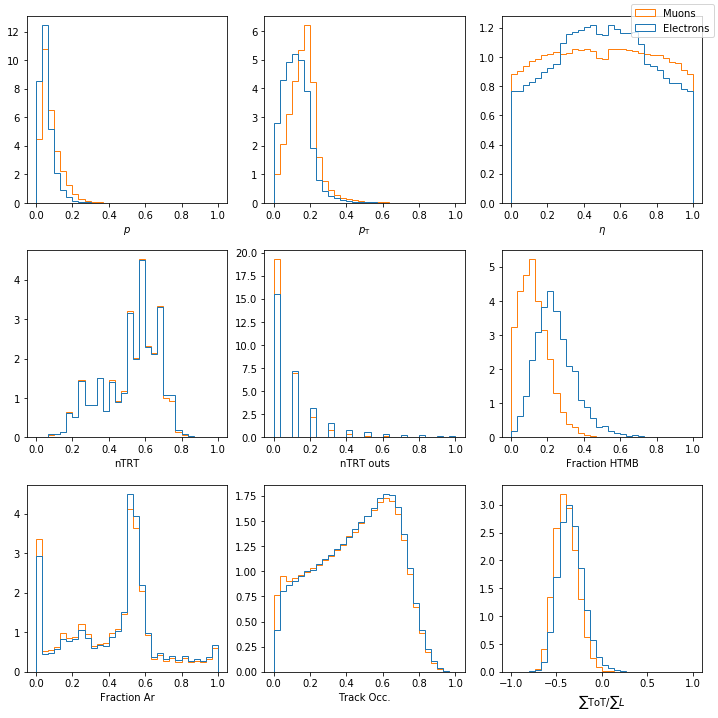

In [7]:
fig, axarr = plt.subplots(3,3,figsize=(10,10))
fortitles = {0:['$p$',axarr[0,0]],
             1:['$p_\mathrm{T}$',axarr[0,1]],
             2:['$\eta$',axarr[0,2]],
             3:['nTRT',axarr[1,0]],
             4:['nTRT outs',axarr[1,1]],
             5:['Fraction HTMB',axarr[1,2]],
             6:['Fraction Ar',axarr[2,0]],
             7:['Track Occ.',axarr[2,1]],
             8:['$\sum\mathrm{ToT}/\sum L$',axarr[2,2]]}

for k,v in fortitles.items():
    v[1].hist([X_train[:,k][y_train>0.5],X_train[:,k][y_train<0.5]],label=['Sig','Bkg'],bins=30,histtype='step',normed=True)
    v[1].set_xlabel(v[0])
    
fig.legend(['Muons','Electrons'])
plt.tight_layout()
fig.savefig(output_path+'/allvars.pdf')

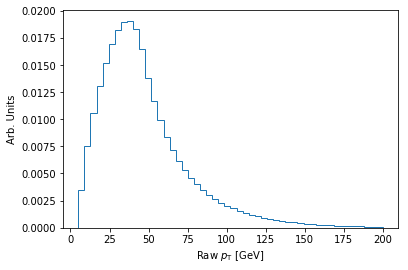

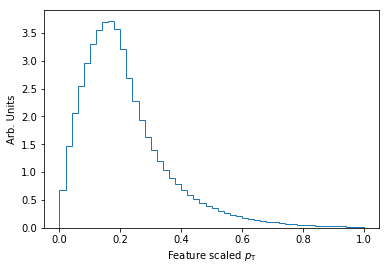

In [8]:
plot_scale_example(sig_file_name,sig_tree,output_path,'p')

## SVM (sklearn)

In [9]:
svm_m = min(50000, y_train.shape[0])

In [10]:
# create model
svm1 = svm.SVC(#C=1.0, #kernel='rbf', #tol=0.001, #gamma='auto',
    probability=True);

In [11]:
# train
time_svm1_start = datetime.now()

svm1.fit(X_train[:svm_m],y_train[:svm_m]);

time_svm1_stop = datetime.now()
print("svm1 training elapsed time: %s" % (strfdelta(time_svm1_stop-time_svm1_start, "{hours} hours, {minutes} minutes, {seconds} seconds")))

svm1 training elapsed time: 0 hours, 4 minutes, 7 seconds


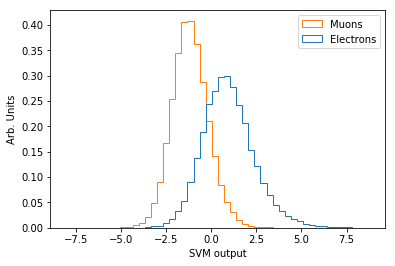

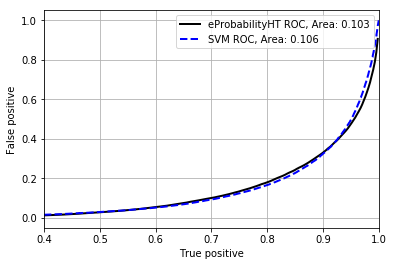

In [12]:
plot_classifier_1D_output(svm1.decision_function(X_test[y_test>0.5]), # el
                          svm1.decision_function(X_test[y_test<0.5]), # mu
                          'SVM', 'svm', output_path
                          #, 'Default sklearn.svm.SVC settings'
                         )

fpr_svm1, tpr_svm1, thresholds_svm1 = roc_curve(y_test, svm1.decision_function(X_test))
roc_svm1 = [tpr_svm1, fpr_svm1, 'SVM', 'svm', 'blue', '--']

plot_roc([roc_eprob, roc_svm1], output_path)

# Keras / Tensorflow work

In [13]:
from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
np.random.seed(7)

input_dimensions = X_train.shape[1]

/home/mbe9/.virtualenvs/trtml/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Default

In [14]:
# create model_default
model_default = Sequential()
model_default.add(Dense(12, input_dim=input_dimensions, activation='relu'))
model_default.add(Dense(8, activation='relu'))
model_default.add(Dense(1, activation='sigmoid'))

model_default.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# train model_default
time_model_default_start = datetime.now()

hist_model_default = model_default.fit(X_train, y_train, epochs=100, batch_size=50, verbose=fit_verbose, validation_data=val_data);

time_model_default_stop = datetime.now()
print("model_default training elapsed time: %s" % (strfdelta(time_model_default_stop-time_model_default_start, "{hours} hours, {minutes} minutes, {seconds} seconds")))

Train on 1506737 samples, validate on 167416 samples
Epoch 1/100
1506737/1506737 [==============================] - 32s 21us/step - loss: 0.3980 - acc: 0.8180 - val_loss: 0.3877 - val_acc: 0.8225
Epoch 2/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3868 - acc: 0.8234 - val_loss: 0.3852 - val_acc: 0.8238
Epoch 3/100
1506737/1506737 [==============================] - 32s 21us/step - loss: 0.3852 - acc: 0.8242 - val_loss: 0.3834 - val_acc: 0.8250
Epoch 4/100
1506737/1506737 [==============================] - 32s 21us/step - loss: 0.3844 - acc: 0.8244 - val_loss: 0.3823 - val_acc: 0.8252
Epoch 5/100
1506737/1506737 [==============================] - 32s 21us/step - loss: 0.3840 - acc: 0.8249 - val_loss: 0.3841 - val_acc: 0.8248
Epoch 6/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3838 - acc: 0.8249 - val_loss: 0.3830 - val_acc: 0.8247
Epoch 7/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.38

1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3807 - acc: 0.8262 - val_loss: 0.3795 - val_acc: 0.8270
Epoch 58/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3807 - acc: 0.8263 - val_loss: 0.3795 - val_acc: 0.8273
Epoch 59/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3807 - acc: 0.8262 - val_loss: 0.3794 - val_acc: 0.8271
Epoch 60/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3807 - acc: 0.8263 - val_loss: 0.3793 - val_acc: 0.8271
Epoch 61/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3807 - acc: 0.8264 - val_loss: 0.3794 - val_acc: 0.8272
Epoch 62/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3807 - acc: 0.8261 - val_loss: 0.3794 - val_acc: 0.8271
Epoch 63/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3807 - acc: 0.8263 - val_loss: 0.3793 - val_acc: 0.8270
Epoch

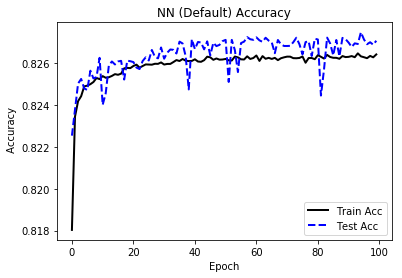

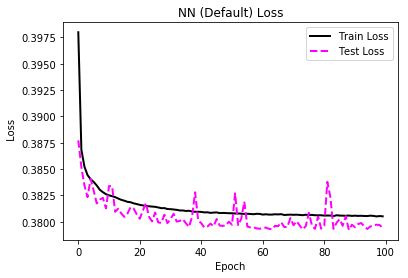

In [44]:
plot_acc_loss_vs_epoch(hist_model_default, 'NN (Default)', 'nn_default', output_path, True, False)
plot_acc_loss_vs_epoch(hist_model_default, 'NN (Default)', 'nn_default', output_path, False, True)

model_default acc: 82.71%


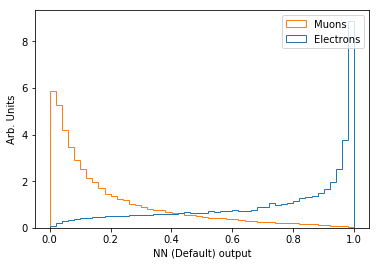

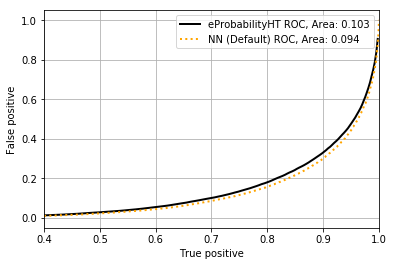

In [17]:
# evaluate model_default
print("model_default %s: %.2f%%" % (model_default.metrics_names[1], model_default.evaluate(X_test,y_test,verbose=0)[1]*100))


plot_classifier_1D_output(model_default.predict(X_test[y_test>0.5], verbose=0), # el
                          model_default.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (Default)', 'nn_default', output_path
                         )

fpr_model_default, tpr_model_default, thresholds_model_default = roc_curve(y_test, model_default.predict(X_test, verbose=0))
roc_model_default = [tpr_model_default, fpr_model_default, 'NN (Default)', 'nn_default', 'orange', ':']

plot_roc([roc_eprob, roc_model_default], output_path)

### Wide

In [18]:
# create model_wide
model_wide = Sequential()
model_wide.add(Dense(24, input_dim=input_dimensions, activation='relu'))
model_wide.add(Dense(16, activation='relu'))
model_wide.add(Dense(1, activation='sigmoid'))

model_wide.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# train model_wide
time_model_wide_start = datetime.now()

hist_model_wide = model_wide.fit(X_train, y_train, epochs=100, batch_size=50, verbose=fit_verbose, validation_data=val_data);

time_model_wide_stop = datetime.now()
print("model_wide training elapsed time: %s" % (strfdelta(time_model_wide_stop-time_model_wide_start, "{hours} hours, {minutes} minutes, {seconds} seconds")))

Train on 1506737 samples, validate on 167416 samples
Epoch 1/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3908 - acc: 0.8213 - val_loss: 0.3816 - val_acc: 0.8259
Epoch 2/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3835 - acc: 0.8249 - val_loss: 0.3857 - val_acc: 0.8228
Epoch 3/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3823 - acc: 0.8257 - val_loss: 0.3809 - val_acc: 0.8257
Epoch 4/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3818 - acc: 0.8257 - val_loss: 0.3799 - val_acc: 0.8261
Epoch 5/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3814 - acc: 0.8257 - val_loss: 0.3818 - val_acc: 0.8257
Epoch 6/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3809 - acc: 0.8260 - val_loss: 0.3825 - val_acc: 0.8257
Epoch 7/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.38

1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3782 - acc: 0.8276 - val_loss: 0.3795 - val_acc: 0.8275
Epoch 58/100
1506737/1506737 [==============================] - 32s 21us/step - loss: 0.3782 - acc: 0.8273 - val_loss: 0.3774 - val_acc: 0.8279
Epoch 59/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3782 - acc: 0.8274 - val_loss: 0.3787 - val_acc: 0.8271
Epoch 60/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3782 - acc: 0.8275 - val_loss: 0.3774 - val_acc: 0.8280
Epoch 61/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3781 - acc: 0.8273 - val_loss: 0.3774 - val_acc: 0.8277
Epoch 62/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3782 - acc: 0.8275 - val_loss: 0.3774 - val_acc: 0.8281
Epoch 63/100
1506737/1506737 [==============================] - 31s 21us/step - loss: 0.3781 - acc: 0.8274 - val_loss: 0.3771 - val_acc: 0.8280
Epoch

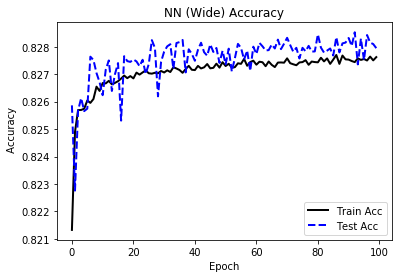

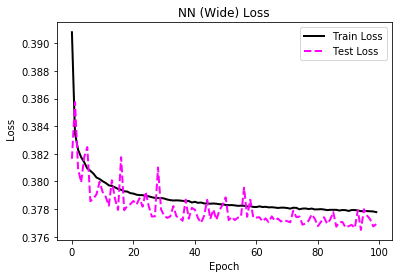

In [45]:
plot_acc_loss_vs_epoch(hist_model_wide, 'NN (Wide)', 'nn_wide', output_path, True, False)
plot_acc_loss_vs_epoch(hist_model_wide, 'NN (Wide)', 'nn_wide', output_path, False, True)

model_wide acc: 82.79%


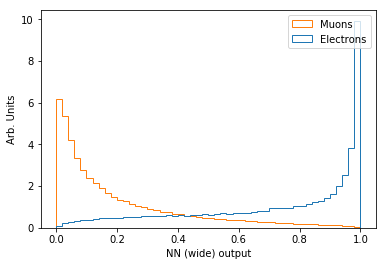

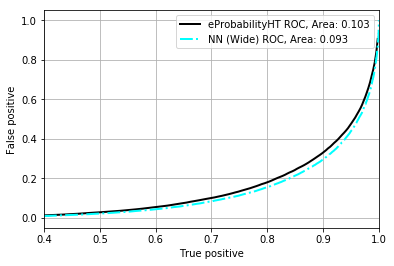

In [21]:
# evaluate model_wide
print("model_wide %s: %.2f%%" % (model_wide.metrics_names[1], model_wide.evaluate(X_test,y_test,verbose=0)[1]*100))


plot_classifier_1D_output(model_wide.predict(X_test[y_test>0.5], verbose=0), # el
                          model_wide.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (wide)', 'nn_wide', output_path
                         )

fpr_model_wide, tpr_model_wide, thresholds_model_wide = roc_curve(y_test, model_wide.predict(X_test, verbose=0))
roc_model_wide = [tpr_model_wide, fpr_model_wide, 'NN (Wide)', 'nn_wide', 'cyan', '-.']

plot_roc([roc_eprob, roc_model_wide], output_path)

### Deep

In [22]:
# create model_deep
model_deep = Sequential()
model_deep.add(Dense(12, input_dim=input_dimensions, activation='relu'))
model_deep.add(Dense(8, activation='relu'))
model_deep.add(Dense(8, activation='relu'))
model_deep.add(Dense(8, activation='relu'))
model_deep.add(Dense(8, activation='relu'))
model_deep.add(Dense(1, activation='sigmoid'))

model_deep.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# train model_deep
time_model_deep_start = datetime.now()

hist_model_deep = model_deep.fit(X_train, y_train, epochs=100, batch_size=50, verbose=fit_verbose, validation_data=val_data);

time_model_deep_stop = datetime.now()
print("model_deep training elapsed time: %s" % (strfdelta(time_model_deep_stop-time_model_deep_start, "{hours} hours, {minutes} minutes, {seconds} seconds")))

Train on 1506737 samples, validate on 167416 samples
Epoch 1/100
1506737/1506737 [==============================] - 35s 23us/step - loss: 0.3948 - acc: 0.8187 - val_loss: 0.3835 - val_acc: 0.8250
Epoch 2/100
1506737/1506737 [==============================] - 35s 23us/step - loss: 0.3852 - acc: 0.8242 - val_loss: 0.3835 - val_acc: 0.8243
Epoch 3/100
1506737/1506737 [==============================] - 35s 23us/step - loss: 0.3838 - acc: 0.8249 - val_loss: 0.3817 - val_acc: 0.8260
Epoch 4/100
1506737/1506737 [==============================] - 35s 23us/step - loss: 0.3832 - acc: 0.8253 - val_loss: 0.3816 - val_acc: 0.8258
Epoch 5/100
1506737/1506737 [==============================] - 35s 23us/step - loss: 0.3828 - acc: 0.8254 - val_loss: 0.3811 - val_acc: 0.8265
Epoch 6/100
1506737/1506737 [==============================] - 35s 23us/step - loss: 0.3825 - acc: 0.8256 - val_loss: 0.3806 - val_acc: 0.8264
Epoch 7/100
1506737/1506737 [==============================] - 35s 23us/step - loss: 0.38

1506737/1506737 [==============================] - 35s 23us/step - loss: 0.3794 - acc: 0.8270 - val_loss: 0.3782 - val_acc: 0.8277
Epoch 58/100
1506737/1506737 [==============================] - 34s 23us/step - loss: 0.3794 - acc: 0.8270 - val_loss: 0.3787 - val_acc: 0.8271
Epoch 59/100
1506737/1506737 [==============================] - 34s 23us/step - loss: 0.3794 - acc: 0.8270 - val_loss: 0.3793 - val_acc: 0.8276
Epoch 60/100
1506737/1506737 [==============================] - 34s 23us/step - loss: 0.3794 - acc: 0.8269 - val_loss: 0.3781 - val_acc: 0.8278
Epoch 61/100
1506737/1506737 [==============================] - 35s 23us/step - loss: 0.3794 - acc: 0.8271 - val_loss: 0.3787 - val_acc: 0.8274
Epoch 62/100
1506737/1506737 [==============================] - 34s 23us/step - loss: 0.3794 - acc: 0.8269 - val_loss: 0.3782 - val_acc: 0.8277
Epoch 63/100
1506737/1506737 [==============================] - 35s 23us/step - loss: 0.3793 - acc: 0.8271 - val_loss: 0.3783 - val_acc: 0.8277
Epoch

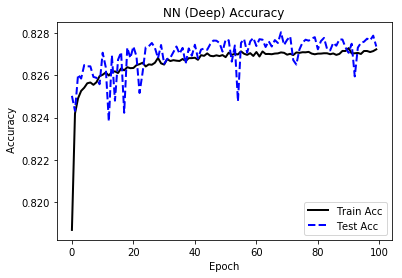

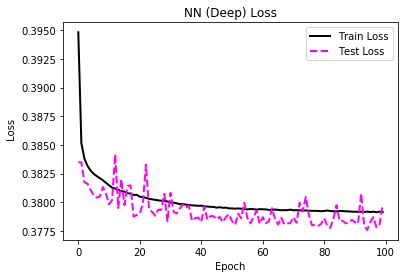

In [46]:
plot_acc_loss_vs_epoch(hist_model_deep, 'NN (Deep)', 'nn_deep', output_path, True, False)
plot_acc_loss_vs_epoch(hist_model_deep, 'NN (Deep)', 'nn_deep', output_path, False, True)

model_deep acc: 82.74%


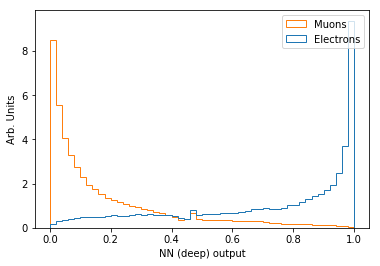

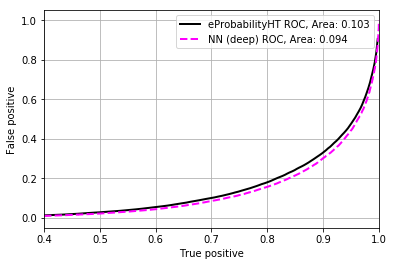

In [25]:
# evaluate model_deep
print("model_deep %s: %.2f%%" % (model_deep.metrics_names[1], model_deep.evaluate(X_test,y_test,verbose=0)[1]*100))


plot_classifier_1D_output(model_deep.predict(X_test[y_test>0.5], verbose=0), # el
                          model_deep.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (deep)', 'nn_deep', output_path
                         )

fpr_model_deep, tpr_model_deep, thresholds_model_deep = roc_curve(y_test, model_deep.predict(X_test, verbose=0))
roc_model_deep = [tpr_model_deep, fpr_model_deep, 'NN (deep)', 'nn_deep', 'magenta', '--']

plot_roc([roc_eprob, roc_model_deep], output_path)

### Compare all models

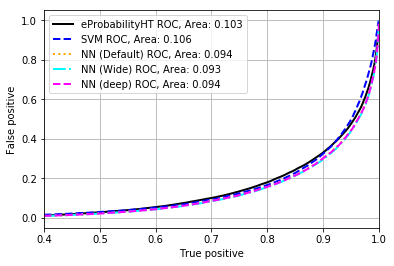

In [26]:
all_models = []
all_models.append(roc_eprob)
all_models.append(roc_svm1)
all_models.append(roc_model_default)
all_models.append(roc_model_wide)
all_models.append(roc_model_deep)

plot_roc(all_models, output_path)

In [27]:
print("Total elapsed time: %s" % (strfdelta(datetime.now()-time_all_start, "{hours} hours, {minutes} minutes, {seconds} seconds")))

Total elapsed time: 2 hours, 49 minutes, 48 seconds
